<a href="https://colab.research.google.com/github/vaccine-lang/facebook-data/blob/main/Facebook_Data_Text_Preparation_(Week_6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facebook Data Text Preparation (Week 6)

Still turning over the reins to the group as a whole, this week we will put the Facebook data into a pipeline.


In [ ]:
# If Colab doesn't have Textacy installed:
#!pip install textacy

# Import common libraries
import pandas as pd
import numpy as np
import os
import pprint as pp
import re
import textacy.preprocessing as tprep
import unicodedata
import spacy

In [ ]:
# Import data files from GitHub

# Set remote (GitHub) and local paths for the data files
GITHUB_ROOT = "https://raw.githubusercontent.com/vaccine-lang/facebook-data/main"
BASE_DIR = "/"
print(f'Files will be downloaded from "{GITHUB_ROOT}"')
print(f'Files will be downloaded to "{BASE_DIR}".')

# Download each file
file_names = ["groups-1", "groups-2", "pages-1", "pages-2"]
print("Downloading data")
for name in file_names:
  cmd = " ".join(['wget', '-P', os.path.dirname(BASE_DIR + name + ".csv"), GITHUB_ROOT + "/data/biased-" + name + ".csv"])
  print("!"+cmd)
  if os.system(cmd) != 0:
    print('  ~~> ERROR')

# Convert the CSVs into Data Frames

data = {}
for name in file_names:
  posts_file = "biased-" + name + ".csv"
  print(posts_file)
  data[name] = pd.read_csv(posts_file)

Files will be downloaded from "https://raw.githubusercontent.com/vaccine-lang/facebook-data/main"
Files will be downloaded to "/".
!wget -P / https://raw.githubusercontent.com/vaccine-lang/facebook-data/main/data/biased-groups-1.csv
!wget -P / https://raw.githubusercontent.com/vaccine-lang/facebook-data/main/data/biased-groups-2.csv
!wget -P / https://raw.githubusercontent.com/vaccine-lang/facebook-data/main/data/biased-pages-1.csv
!wget -P / https://raw.githubusercontent.com/vaccine-lang/facebook-data/main/data/biased-pages-2.csv
biased-groups-1.csv


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


biased-groups-2.csv
biased-pages-1.csv
biased-pages-2.csv


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,37,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Reshape Data

The Facebook data is separated into four files, two each for pages and groups. We only want one file, however. 

Also, we don't care about the extraneous data. We only want text. However, initial exploratory data analysis (see previous Colab) indicated that there is no consistent field for the text of what was shared to Facebook. Instead, there seem to be four fields, `Message`, `Image Text`, `Link Text`, and `Description`, that carry content that may interest us.

Let's reduce each data frame to just those four fields and then merge (concatenate) them together.

In [ ]:
interesting_columns = ["Message", "Image Text", "Link Text", "Description"]

df = pd.concat([data[key][interesting_columns] for key in file_names], ignore_index=True)

# Let's rename the columns.
new_columns = ["message", "imageText", "linkText", "linkDescription"]
df.columns = new_columns

# Since NaN is type "float", which won't work in the join below,
# let's convert all the NaNs to "".
df.fillna("", inplace=True)

# and let's concatenate the columns into a new column, 
# so we capture all of the data as a single text object.
df["text"] = df.apply(lambda row: " ".join([row[column] for column in new_columns]), axis=1)

## Text "Cleaning"

Now that all of the text for the entire corpus is in one dataframe (and one column, to boot), we can start "cleaning" the text following the graphic on page 90. This involves:

* identifying noise
* removing noise
* normalizing characters
* masking data

### Identifying Noise

Let's use the `impurity` function from the book to get a sense of how "impure" the each message is.

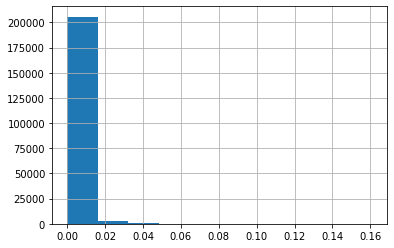

In [ ]:
RE_SUSPICIOUS = re.compile(r'[&#<>\[\]\\]')

def impurity(text, min_len=10):
  """returns the share of suspicious characters in a text"""
  if text == None or len(text) < min_len:
    return 0
  else:
    return len(RE_SUSPICIOUS.findall(text))/len(text)

df["impurity"] = df["text"].apply(impurity, min_len=50)
df["impurity"].hist()

The text is rather "pure," in that does not have many instances of `&`, `#`, `<`, `>`, `[`, `]`, and `\`. All the same, let's see the top "impure" posts:

In [ ]:
df[["text", "impurity"]].sort_values(by="impurity", ascending=False).head()

,text,impurity
163920,Victory Loves Preparation. <3 <3 <3 <3 <3 <3 <...,0.160714
57863,Wayne #The #Truth #Against #The #Trolls #Lie...,0.133333
46784,Wayne #The #Truth #NOT #CHANNEL9 #Bias #Ver...,0.120000
59190,Wayne #My #Answer to the #Lying #Fake #News ...,0.115385
84709,#peace #training #canada #saturday #freedom #m...,0.106061


What do we think?

### Normalizing with Textacy

Given how "clean" the text seems, we can move to normalizing with textacy as indicated in the text on p. 99. All of the available Textacy preprocessing functions are listed [on their API documentation website](https://textacy.readthedocs.io/en/latest/api_reference/preprocessing.html#replace).

But first, let's solve the emoji problem so we can add a solution into the pipeline. Last week, we discussed how it seems wrong to just remove them. And even textacy proposes replacing any emoji with _EMOJI_. But maybe we can replace emoji with their unicode names.

In [ ]:
emoji = "🤬"

# Every emoji has a unicode description:
print(unicodedata.name(emoji))

SERIOUS FACE WITH SYMBOLS COVERING MOUTH


In [ ]:
# We can use this function, then, with textacy's emoji replace function to replace the emoji.

test_text = "🤬 new lines, many lettering sets 爱, and even emoji 🤠"
tprep.replace.emojis(test_text, lambda reMatch: unicodedata.name(reMatch[0]))

'SERIOUS FACE WITH SYMBOLS COVERING MOUTH new lines, many lettering sets 爱, and even emoji FACE WITH COWBOY HAT'

In [ ]:
# So let's write a function we can perform in our normalization pipeline.

def emoji_in_context(text):
  try:
    return tprep.replace.emojis(text, lambda reMatch: unicodedata.name(reMatch[0]))
  except:
    return "_EMOJI_"

In [ ]:
# If Colab doesn't have Textacy installed:
#!pip install textacy

def normalize_pipeline(text, axis=1):
  text = emoji_in_context(text)
  text = re.sub(r"[\[\](){}]", "", text)
  pipeline = tprep.make_pipeline(
    tprep.normalize.repeating_chars,
    tprep.normalize.quotation_marks,
    tprep.remove.accents,
    #tprep.remove.brackets, # Removes *content* inside [], {}, ()
    tprep.replace.currency_symbols,
    tprep.replace.urls,
    tprep.replace.user_handles,
    tprep.replace.emails,
    tprep.replace.phone_numbers,
    tprep.replace.numbers
  )
  return pipeline(text, chars=".,!?") # chars gets fed into tprep.normalize.repeating_chars

df["normText"] = df["text"].apply(normalize_pipeline, axis=1)

### Data Masking

Presumably, through the above normalizations, the data should be masked, and we can move on to doing linguistic processing.

## Linguistic Processing with spaCy

Linguistic processing is made up of four parts:

* Tokenization
* Part of speech tagging
* Lemmatization
* Named-entity recognition

In [ ]:
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [69]:
sample = df.sample(100)
sample["spacyDoc"] = sample["normText"].apply(nlp)